In [29]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.special as sc
import copy

In [30]:
class neuralNetwork:
    def __init__(self, input_nodes, hidden_nodes, output_nodes, learning_rate):
        self.inodes = input_nodes
        self.hnodes = hidden_nodes
        self.onodes = output_nodes
        self.lr = learning_rate

        self.wih = np.random.normal(0.0, pow(self.hnodes, -0.5), (self.hnodes, self.inodes))
        self.who = np.random.normal(0.0, pow(self.onodes, -0.5), (self.onodes, self.hnodes))
        self.activation_function = lambda x: sc.expit(x)

    def train(self, inputs, targets):
        inputs = np.array(inputs, dtype=float, ndmin=2).T
        targets = np.array(targets, dtype=float, ndmin=2).T

        hidden_inputs = np.dot(self.wih, inputs)
        hidden_outputs = self.activation_function(hidden_inputs)

        finall_inputs = np.dot(self.who, hidden_outputs)
        finall_outputs = self.activation_function(finall_inputs)

        #Training loss
        training_loss = np.mean((targets-finall_outputs)**2)

        output_errors = (targets - finall_outputs)
        hiidden_errors = np.dot(self.who.T, output_errors)

        self.who += self.lr * np.dot((output_errors * finall_outputs * (1.0 - finall_outputs)), np.transpose(hidden_outputs))
        self.wih += self.lr * np.dot((hiidden_errors * hidden_outputs * (1.0 - hidden_outputs)), np.transpose(inputs))
        
        return training_loss

    def query(self, inputs):
        inputs = np.array(inputs, dtype=float, ndmin=2).T
        
        hidden_inputs = np.dot(self.wih, inputs)
        hidden_outputs = self.activation_function(hidden_inputs)

        final_inputs = np.dot(self.who, hidden_outputs)
        final_outputs = self.activation_function(final_inputs)

        return final_outputs
    
    def backquery(self, targets):
        targets = np.array(targets, ndmin=2).T
        final_inputs = sc.logit(targets)

        hidden_outputs = np.dot(self.who.T, final_inputs)
        hidden_outputs = np.interp(hidden_outputs, (hidden_outputs.min(), hidden_outputs.max()), (0.01, 0.99))

        hidden_inputs = sc.logit(hidden_outputs)

        inputs = np.dot(self.wih.T, hidden_inputs)

        inputs = np.interp(inputs, (inputs.min(), inputs.max()), (0.01, 0.99))

        return inputs
        


In [31]:
input_nodes = 784
hidden_nodes = 100
output_nodes = 10

learning_rate = 0.1

network = neuralNetwork(input_nodes, hidden_nodes, output_nodes, learning_rate)

In [32]:
training_data_file = open("data/mnist_train.csv")
test_data_file = open("data/mnist_test.csv")

training_data_list = training_data_file.readlines()
test_data_list = test_data_file.readlines()

training_data_file.close()
test_data_file.close()


In [33]:

def network_test(network_under_test, test_data_list):
    correct_answers = 0
    for record in test_data_list:
        all_values = record.split(',')
        inputs = (np.array(all_values[1:], dtype=float)/255*0.99)+0.01

        output = network_under_test.query(inputs)

        if np.argmax(output) == int(all_values[0]):
            correct_answers += 1

    return correct_answers, 10000 - correct_answers, correct_answers/100

correct_answers, mistakes, percent = network_test(network, test_data_list)

print(f"Correct: {correct_answers}\nMistakes: {mistakes}\nPercent: {percent}")

Correct: 1126
Mistakes: 8874
Percent: 11.26


In [34]:
epochs = 30
global_epoch_loss = []
accuracy_per_epoch = []


for _ in range(epochs):
    epoch_loss = []
    for record in training_data_list:
        all_values = record.split(',')
        inputs = (np.array(all_values[1:], dtype=float)/255*0.99)+0.01
        targets = np.zeros(output_nodes) + 0.01
        targets[int(all_values[0])] += 0.99

        training_loss = network.train(inputs, targets)
        epoch_loss.append(training_loss)

    
    global_epoch_loss.append(np.mean(epoch_loss))
    _, _, accuracy = network_test(network, test_data_list)
    accuracy_per_epoch.append(accuracy)
    
    if accuracy < accuracy_per_epoch[-1]:
        worst_model = copy.deepcopy(network)

    if accuracy > accuracy_per_epoch[-1]:
        best_model = copy.deepcopy(network)

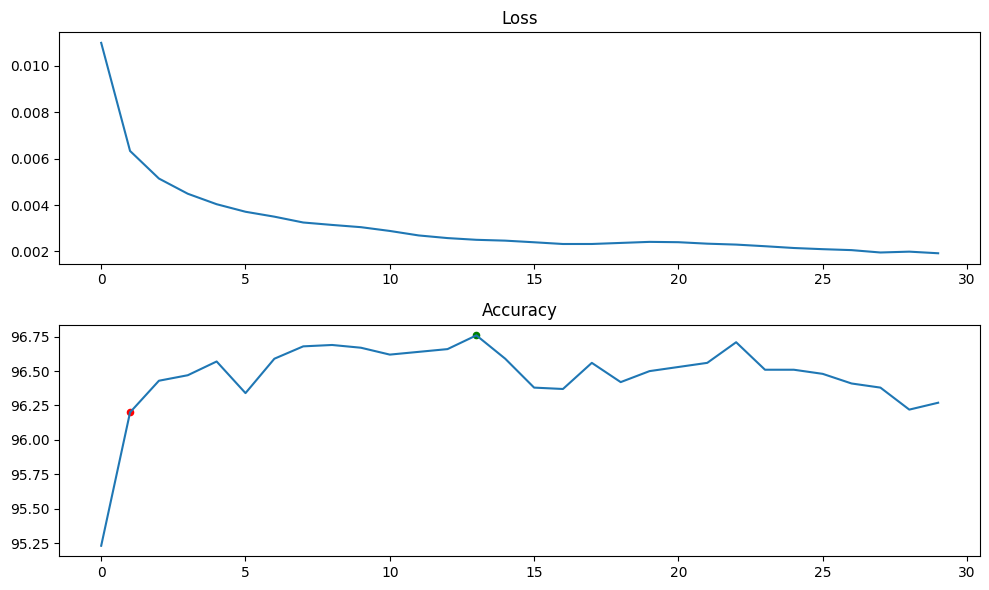

In [37]:
temp = np.argpartition(accuracy_per_epoch, 1)
min_second_index = temp[1]
min_second = accuracy_per_epoch[min_second_index]



plt.figure(figsize=(10, 6))

plt.subplot(2, 1, 1)
plt.plot(global_epoch_loss)
plt.title("Loss")

plt.subplot(2, 1, 2)
plt.plot(accuracy_per_epoch)
plt.scatter(np.argmax(accuracy_per_epoch), accuracy_per_epoch[np.argmax(accuracy_per_epoch)], color="green", s=20)
plt.scatter(min_second_index, min_second, color="red", s=20)
plt.title("Accuracy")

plt.tight_layout()
plt.show()

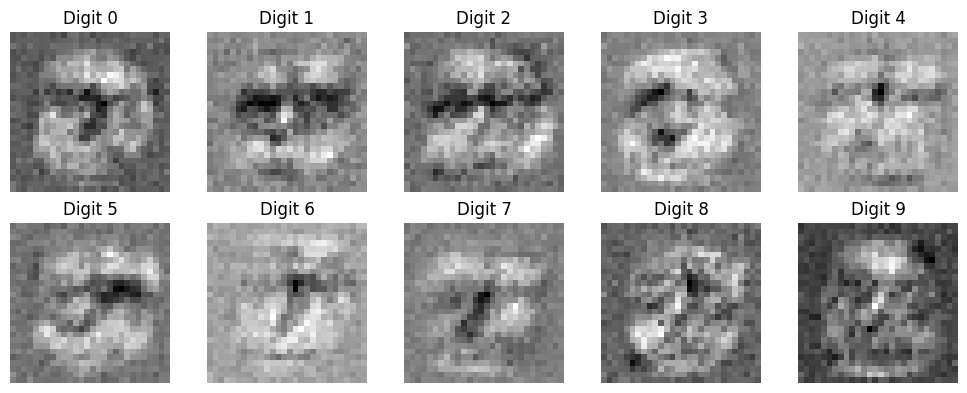

In [36]:
all_numbers = []

for i in range(10):
    targets = np.zeros(output_nodes) + 0.01
    targets[i] = 0.99
    all_numbers.append(best_model.backquery(targets))



all_numbers = np.array(all_numbers)
all_numbers.shape
all_numbers = all_numbers.squeeze()
all_numbers.shape

fig, axes = plt.subplots(2, 5, figsize=(10, 4))

for i, ax in enumerate(axes.flat):
    ax.imshow(all_numbers[i].reshape(28, 28), cmap='gray')
    ax.set_title(f'Digit {i}')
    ax.axis('off')

plt.tight_layout()
plt.show()


    